<h1> <strong> <center> Model 2: Neural Network </center> </strong>  </h1> 

Our third model classifies a dataset of Urdu-language text articles using a manual implementation of a simple sequential Neural Network. 

<h4> 1) Library Imports </h4>

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)
import torch
import torch.nn as nn
import torch.optim as optim

In [17]:
df = pd.read_csv('scraped_data.csv')
df.head()

,gold_label,processed_content,processed_title
0,entertainment,مشہور پنجابی گلوکار اداکار بلجیت دوران معلومات...,بھولنا بھی ۳ گانا پرانا بلجیت کارتک دھماکا دار...
1,entertainment,بلا ووڈ دبنگ خان ممبئی ما شاہ رخ خان پرتعیش رہ...,سلمان خان شاہ رخ خان منت متعلق بڑا انکشاف
2,entertainment,بھارتی فلم ٹی وی معروف اداکارہ نیٹ فلکس مشہور ...,نیلم کوشیاری غیر متوقع سوال پرانا حیران حاضرین...
3,entertainment,شہرت بلندی چھونا بلا ووڈ اداکار پربھاری تنا بڑ...,اداکار پربھاری فلم انڈسٹری بڑا معاہدہ کرلیا
4,entertainment,مشہور بھارتی سیریز ترک مہت الٹنا چشمہ سیٹ پران...,ترک مہت سیٹ پرانا جھگڑا دلیپ جوشی شہ چھوڑنا دھمکی


<h4> 2) Data Splitting </h4>

- This part involves extracting the `gold_label` column from the dataframe to form the labels data.
- It also involves using Scikit-Learn's `train_test_split` function to split the data into Training, Validation, and Testing datasets

In [18]:
X = df.drop('gold_label', axis=1)  
y = df['gold_label'] 

train_size = 0.8
validation_size = 0.10
test_size = 0.10

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size= test_size, random_state= 42, stratify= y)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size= (validation_size / (train_size + validation_size)), random_state= 42, stratify= y_train_validation)

print(f"Training dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Validation dataset shape: {X_validation.shape}, {y_validation.shape}")
print(f"Test dataset shape: {X_test.shape}, {y_test.shape}")

Training dataset shape: (2199, 2), (2199,)
Validation dataset shape: (275, 2), (275,)
Test dataset shape: (275, 2), (275,)


<h4> 3) Label Encoding and Vectorization </h4>

- Here, we convert the categorical labels into numeric format using a custom class, ManualLabelEncoder
- Then, we convert text into numerical features using another custom class, ManualCountVectorizer.

In [19]:
class ManualLabelEncoder:
    def __init__(self):
        self.label_to_int = {}
        self.int_to_label = {}

    def fit(self, labels):
        unique_labels = sorted(set(labels))
        self.label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        self.int_to_label = {idx: label for label, idx in self.label_to_int.items()}
        return self

    def transform(self, labels):
        return [self.label_to_int[label] for label in labels]

    def fit_transform(self, labels):
        self.fit(labels)
        return self.transform(labels)

class ManualCountVectorizer:
    def __init__(self, max_features=None):
        self.max_features = max_features
        self.vocabulary = {}

    def fit(self, documents):
        word_counts = {}
        for doc in documents:
            words = doc.split()
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1

        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        if self.max_features:
            sorted_words = sorted_words[:self.max_features]

        self.vocabulary = {word: idx for idx, (word, _) in enumerate(sorted_words)}
        return self

    def transform(self, documents):
        feature_vectors = []
        for doc in documents:
            vector = [0] * len(self.vocabulary)
            words = doc.split()
            for word in words:
                if word in self.vocabulary:
                    vector[self.vocabulary[word]] += 1
            feature_vectors.append(vector)
        return np.array(feature_vectors)

    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)

In [20]:
label_encoder = ManualLabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train.tolist())
y_validation_enc = label_encoder.transform(y_validation.tolist())
y_test_enc = label_encoder.transform(y_test.tolist())

vectorizer = ManualCountVectorizer(max_features=5000)
X_train_vectors = vectorizer.fit_transform(X_train['processed_content'].tolist())
X_validation_vectors = vectorizer.transform(X_validation['processed_content'].tolist())
X_test_vectors = vectorizer.transform(X_test['processed_content'].tolist())

X_train_tensor = torch.tensor(X_train_vectors, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_validation_tensor = torch.tensor(X_validation_vectors, dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation_enc, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_vectors, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

<h4> 4) Neural Network Class </h4>

The code defines a neural network model for classifying Urdu articles, consisting of fully connected layers with ReLU activations, dropout for regularization, and a final softmax layer for outputting class probabilities.

In [21]:
class UrduArticleClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(UrduArticleClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.fc(x)


In [22]:
input_size = 5000  
hidden_size = 128
num_classes = len(label_encoder.int_to_label) 
model = UrduArticleClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validation_tensor)
        val_loss = criterion(val_outputs, y_validation_tensor)

<h4> 5) Training on Validation Dataset</h4>

This code trains and evaluates an `UrduArticleClassifier` model for text classification using a training loop (`fit`) and a validation function (`evaluate`), using mini-batch gradient descent, AdamW optimizer, and cross-entropy loss over multiple epochs to train and evaluate the model.

In [23]:
def evaluate(model, criterion, X, y, batch_size):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
    
    accuracy = correct / len(y)
    return total_loss / (len(X) // batch_size), accuracy


In [24]:
def fit(model, X_train, y_train, X_val, y_val, optimizer, loss_fn, epochs, batch_size):
    train_loss_list = []
    train_accuracy_list = []
    validation_loss_list = []
    validation_accuracy_list = []

    for epoch in range(epochs):
        print(f"Starting epoch {epoch + 1}/{epochs}...")

        model.train()
        total_train_loss = 0
        correct_train = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()

        train_loss = total_train_loss / (len(X_train) // batch_size)
        train_accuracy = correct_train / len(X_train)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        validation_loss, validation_accuracy = evaluate(model, loss_fn, X_val, y_val, batch_size)
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy * 100:.2f}%")

    return train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list


In [25]:
input_size = X_train_vectors.shape[1] 
num_classes = len(label_encoder.int_to_label) 
num_layers = 1 

model = UrduArticleClassifier(input_size=input_size, num_classes=num_classes,)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4) 
criterion = nn.CrossEntropyLoss()

epochs = 100
batch_size = 64

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = fit(model=model, X_train=X_train_tensor, y_train=y_train_tensor, X_val=X_validation_tensor, y_val=y_validation_tensor, optimizer=optimizer, loss_fn=criterion, epochs=epochs, batch_size=batch_size)

Starting epoch 1/100...
Epoch 1/100
Train Loss: 1.5199, Train Accuracy: 48.29%
Validation Loss: 1.4522, Validation Accuracy: 81.45%
Starting epoch 2/100...
Epoch 2/100
Train Loss: 1.2130, Train Accuracy: 76.44%
Validation Loss: 1.3025, Validation Accuracy: 86.55%
Starting epoch 3/100...
Epoch 3/100
Train Loss: 1.1016, Train Accuracy: 85.86%
Validation Loss: 1.2351, Validation Accuracy: 93.09%
Starting epoch 4/100...
Epoch 4/100
Train Loss: 1.0488, Train Accuracy: 90.63%
Validation Loss: 1.2135, Validation Accuracy: 94.18%
Starting epoch 5/100...
Epoch 5/100
Train Loss: 1.0230, Train Accuracy: 92.77%
Validation Loss: 1.2003, Validation Accuracy: 95.27%
Starting epoch 6/100...
Epoch 6/100
Train Loss: 1.0060, Train Accuracy: 93.77%
Validation Loss: 1.1968, Validation Accuracy: 94.91%
Starting epoch 7/100...
Epoch 7/100
Train Loss: 1.0007, Train Accuracy: 94.59%
Validation Loss: 1.1947, Validation Accuracy: 96.36%
Starting epoch 8/100...
Epoch 8/100
Train Loss: 0.9899, Train Accuracy: 95.3

<h4> 6) Plotting Loss and Accuracy Curve for Training and Validation Datasets </h4>

The code plots two subplots showing the loss and accuracy curves for both training and validation over epochs.

In [26]:
def plot_training_history(train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss', color='blue')
    plt.plot(validation_loss_list, label='Validation Loss', color='red')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_list, label='Train Accuracy', color='blue')
    plt.plot(validation_accuracy_list, label='Validation Accuracy', color='red')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

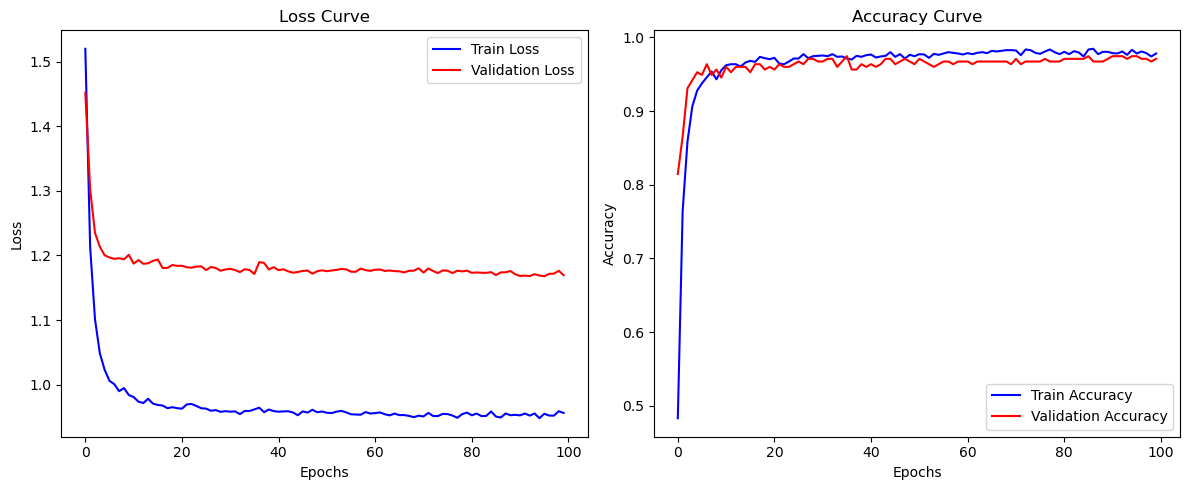

In [27]:
plot_training_history(train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list)

In [28]:
test_loss, test_acc = evaluate(model, criterion, X_test_tensor, y_test_tensor, batch_size)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9745


<h4> 7) Testing on the Test Dataset </h4>

Here, we test our model on the validation dataset and assess its performance using the following metrics:
- Accuracy
- Class-wise Precision
- Class-wise Recall
- Macro F1 Score
- Confusion Matrix

In [29]:
def make_heat_map(confusion_matrix, title):
  plt.figure(figsize=(12, 6))
  sns.heatmap(confusion_matrix, fmt="d", annot= True, cmap= "Blues", cbar= True)
  plt.title(title)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")
  plt.show()
    
def evaluate(y_true, y_pred, target_names):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred)
    make_heat_map(cm, "Confusion Matrix")

Accuracy: 97.45%

Classification Report:
                    precision    recall  f1-score   support

          business       1.00      1.00      1.00        54
     entertainment       1.00      0.98      0.99        61
science-technology       0.91      0.94      0.93        34
            sports       1.00      0.98      0.99        63
             world       0.94      0.95      0.94        63

          accuracy                           0.97       275
         macro avg       0.97      0.97      0.97       275
      weighted avg       0.98      0.97      0.97       275



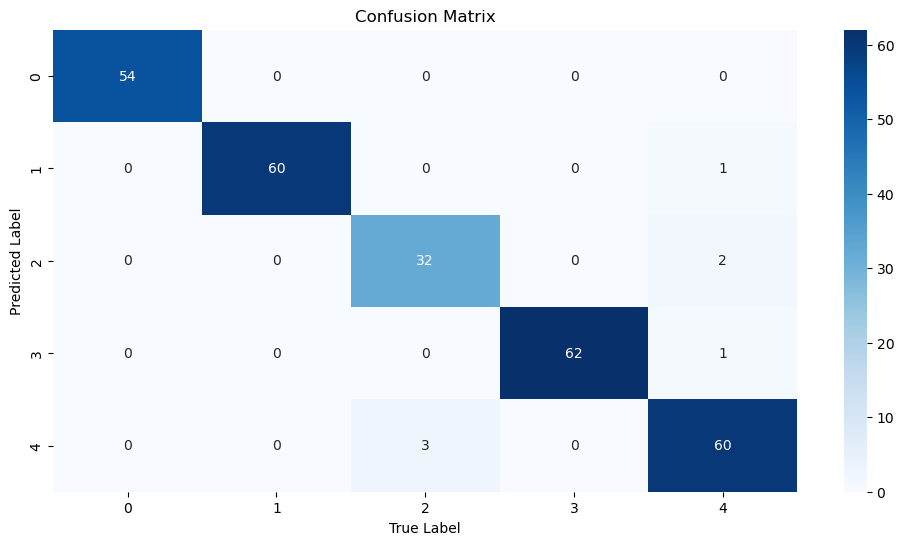

In [30]:
model.eval()  
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)  

y_pred_labels = [label_encoder.int_to_label[idx] for idx in y_pred.numpy()]
evaluate(y_test.tolist(), y_pred_labels, target_names=list(label_encoder.int_to_label.values()))